In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [3]:
import imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [5]:
import joblib

In [4]:
# making sure it's 3.9
from platform import python_version
print(python_version())

3.9.1


In [5]:
# based on previous testing, decided to use:
## tfidf
## logistic regression
### {'logreg__C': 10.0,
### 'logreg__penalty': 'l2',
### 'logreg__random_state': 1,
### 'logreg__solver': 'saga'}

In [6]:
# FINALLY ! here we go

In [7]:
# loading data files

# has clean review text
dataset = pd.read_json("dramainfo_revclean.json")

# tfidf
tfidf_rev = np.load("tfidfvec.npy")
tfidf_vocab = np.load("tfidfvocab.npy")

In [8]:
tfidf_dataset = pd.DataFrame(tfidf_rev, columns=[word+"_tfidf" for word in tfidf_vocab])
tfidf_dataset = tfidf_dataset.join(dataset.iloc[:,-17:-1])

In [9]:
tfidf_dataset.iloc[:,:-16].columns

Index(['aa_tfidf', 'aaa_tfidf', 'aaaa_tfidf', 'aaaaa_tfidf', 'aaaaaa_tfidf',
       'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaareview_tfidf',
       'aaaaaand_tfidf', 'aaaaah_tfidf', 'aaaaahhh_tfidf', 'aaaaand_tfidf',
       ...
       'zyl_tfidf', 'zyls_tfidf', 'zyq_tfidf', 'zyt_tfidf', 'zz_tfidf',
       'zzh_tfidf', 'zzhs_tfidf', 'zzs_tfidf', 'zzz_tfidf', 'zzzzz_tfidf'],
      dtype='object', length=59557)

In [10]:
# names of all genre columns
bat_targets = list(dataset.iloc[:,-17:-1].columns)
print(bat_targets)

['romance', 'sitcom_comedy', 'comedy', 'war_historical', 'political_drama', 'thriller', 'friendship', 'melodrama_romance', 'drama', 'action', 'historical', 'youth_school', 'fantasy_supernatural_horror', 'mystery', 'life', 'family']


In [9]:
# if ratio is <0.4, do oversample w strat 0.5
# else only downsample
def single_strat(minority,majority):
    minr, maxr = (0.4,0.6)
    
    orig_ratio = minority/majority
    
    if orig_ratio >= minr and orig_ratio <= maxr:
        return (None,0.8)
    elif orig_ratio > maxr:
        return (None,0.8)
    else: return (0.5,0.8)

In [10]:
def samp_strats(dataset=dataset, bat_targets=bat_targets):
    # dict[genre] = (over strat, under strat)
    samp_dict = dict()

    for gen in bat_targets:
        counts = Counter(dataset[gen])   
        is_frac = counts[1]/(counts[0]+counts[1])

        if is_frac >= 0.45 and is_frac <= 0.55:
            samp_dict[gen]= (None,None)

        else:
            samp_dict[gen] = single_strat(min(counts[0],counts[1]),
                                          max(counts[0],counts[1]))

    return samp_dict

In [11]:
# over,under
samp_dict = samp_strats()
samp_dict

{'romance': (None, 0.8),
 'sitcom_comedy': (None, 0.8),
 'comedy': (None, 0.8),
 'war_historical': (0.5, 0.8),
 'political_drama': (None, None),
 'thriller': (0.5, 0.8),
 'friendship': (0.5, 0.8),
 'melodrama_romance': (None, 0.8),
 'drama': (None, None),
 'action': (0.5, 0.8),
 'historical': (0.5, 0.8),
 'youth_school': (0.5, 0.8),
 'fantasy_supernatural_horror': (0.5, 0.8),
 'mystery': (0.5, 0.8),
 'life': (0.5, 0.8),
 'family': (0.5, 0.8)}

In [85]:
def run_clf(genre, tfidf_dataset=tfidf_dataset, samp_dict=samp_dict):    
    ov_strat,un_strat = samp_dict[genre]

    tt_random_state = 18
    # np arrays are faster for some reason
    X_train, X_test, y_train, y_test = train_test_split(np.array(tfidf_dataset.iloc[:,:-16]),
                                                        np.array(tfidf_dataset[genre]),
                                                        test_size=0.3,
                                                        random_state=tt_random_state)
    
    # resampling
    if ov_strat != None and un_strat != None:
        over = RandomOverSampler(sampling_strategy=ov_strat)
        under = RandomUnderSampler(sampling_strategy=un_strat)
        X_train,y_train = over.fit_resample(X_train,y_train)
        X_train,y_train = under.fit_resample(X_train,y_train)
    elif ov_strat == None and un_strat != None:
        under = RandomUnderSampler(sampling_strategy=un_strat)
        X_train,y_train = under.fit_resample(X_train,y_train)
    else: pass
    
    # classifier
    clf = LogisticRegression(penalty="l2", C=10.0, solver="saga", random_state=1)
    
    clf.fit(X_train,y_train)
    
    # training,test info to return
    tt_split = {"X_test":X_test,
                "y_test":y_test}
    
    return clf, tt_split

In [88]:
clf_dict = dict()
test_vars = dict()

for genre in bat_targets:
    print("Running for ...{:>30}".format(genre))
    
    clf,tt_split = run_clf(genre)
    clf_dict[genre] = clf
    
    test_vars[genre] = {"X_test":tt_split["X_test"],
                        "y_test":tt_split["y_test"]}

Running for ...                       romance
Running for ...                 sitcom_comedy
Running for ...                        comedy
Running for ...                war_historical
Running for ...               political_drama
Running for ...                      thriller
Running for ...                    friendship
Running for ...             melodrama_romance
Running for ...                         drama
Running for ...                        action
Running for ...                    historical
Running for ...                  youth_school
Running for ...   fantasy_supernatural_horror
Running for ...                       mystery
Running for ...                          life
Running for ...                        family


In [12]:
# saving models and test data
for genre in bat_targets:
    mod_filename = genre+"__model.sav"
    joblib.dump(clf_dict[genre],mod_filename)
    
    xtest_filename = genre+"__xtest.npy"
    ytest_filename = genre+"__ytest.npy"
    np.save(xtest_filename, test_vars[genre]["X_test"])
    np.save(ytest_filename, test_vars[genre]["y_test"])

In [11]:
# load models, test data

clf_dict = dict()
test_vars = dict()

for genre in bat_targets:
    mod_filename = genre+"__model.sav"
    clf_dict[genre] = joblib.load(mod_filename)
    
    xtest_filename = genre+"__xtest.npy"
    ytest_filename = genre+"__ytest.npy"
    test_vars[genre] = {"X_test":np.load(xtest_filename),
                         "y_test":np.load(ytest_filename)}

In [12]:
def display_metrics(y_test,y_pred):
    accuracy = metrics.accuracy_score(y_test,y_pred)
    precision = metrics.precision_score(y_test,y_pred,
                                        average="binary")
    recall = metrics.recall_score(y_test,y_pred,
                                  average="binary")
    f1 = metrics.f1_score(y_test,y_pred,
                          average="binary")
    auc = metrics.roc_auc_score(y_test,y_pred)
    
    score_str = "    {:<14}{:>10.4f}"
    
    print("{:*<40}".format(""))
    print("  GENRE: {:<30}".format(genre))
    print("{:`<40}".format(""))
    print(score_str.format("Accuracy:",accuracy))
    print(score_str.format("Precision:",precision))
    print(score_str.format("Recall:",recall))
    print(score_str.format("F1:",f1))
    print(score_str.format("AUC:",auc))
    print("{:`<40}".format(""))
    cf = metrics.confusion_matrix(y_test,y_pred)
    cf_display = metrics.ConfusionMatrixDisplay(cf).plot()
    plt.show()
    print("{:*<40}\n".format(""))
    
        
    metric_data = {"accuracy":accuracy,
                   "precision":precision,
                   "recall":recall,
                   "fl":f1,
                   "auc":auc}
    metric_ser = pd.Series(metric_data,name=genre)
    return metric_ser

In [13]:
def get_result_df(y_pred, dataset=dataset):
    # get splits to join up the predictions, same random state as before
    # now with indices
    X_train, X_test, y_train, y_test = train_test_split(dataset,
                                                        dataset[genre],
                                                        test_size=0.3,
                                                        random_state=18)
    
    # need an index for y_pred
    y_df = pd.DataFrame({genre+"_test":y_test,genre+"_pred":y_pred})
    
    return y_df

****************************************
  GENRE: romance                       
````````````````````````````````````````
    Accuracy:         0.8351
    Precision:        0.8470
    Recall:           0.9077
    F1:               0.8763
    AUC:              0.8058
````````````````````````````````````````


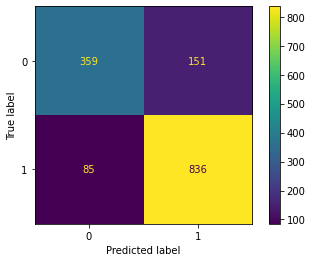

****************************************

****************************************
  GENRE: sitcom_comedy                 
````````````````````````````````````````
    Accuracy:         0.7596
    Precision:        0.6494
    Recall:           0.6931
    F1:               0.6705
    AUC:              0.7445
````````````````````````````````````````


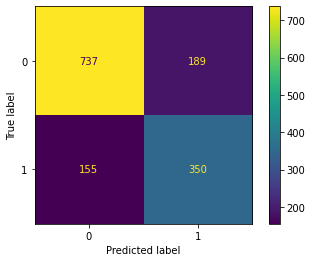

****************************************

****************************************
  GENRE: comedy                        
````````````````````````````````````````
    Accuracy:         0.7666
    Precision:        0.6518
    Recall:           0.7042
    F1:               0.6770
    AUC:              0.7520
````````````````````````````````````````


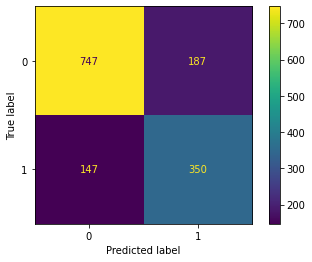

****************************************

****************************************
  GENRE: war_historical                
````````````````````````````````````````
    Accuracy:         0.9441
    Precision:        0.7313
    Recall:           0.8497
    F1:               0.7861
    AUC:              0.9034
````````````````````````````````````````


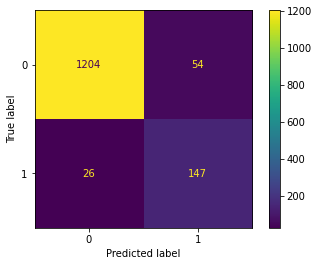

****************************************

****************************************
  GENRE: political_drama               
````````````````````````````````````````
    Accuracy:         0.6031
    Precision:        0.6429
    Recall:           0.6199
    F1:               0.6312
    AUC:              0.6013
````````````````````````````````````````


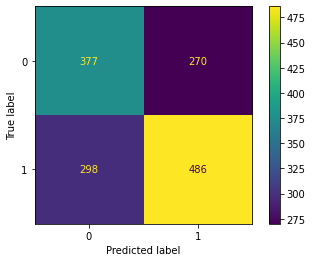

****************************************

****************************************
  GENRE: thriller                      
````````````````````````````````````````
    Accuracy:         0.8973
    Precision:        0.5130
    Recall:           0.5232
    F1:               0.5180
    AUC:              0.7323
````````````````````````````````````````


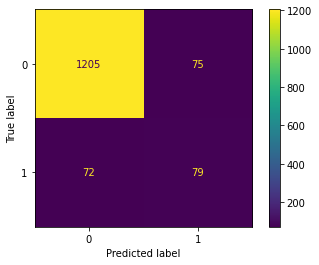

****************************************

****************************************
  GENRE: friendship                    
````````````````````````````````````````
    Accuracy:         0.8658
    Precision:        0.3212
    Recall:           0.3985
    F1:               0.3557
    AUC:              0.6561
````````````````````````````````````````


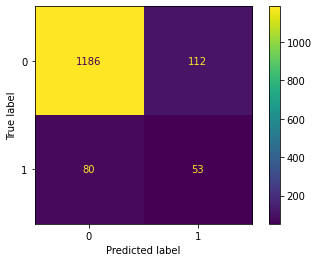

****************************************

****************************************
  GENRE: melodrama_romance             
````````````````````````````````````````
    Accuracy:         0.8414
    Precision:        0.8540
    Recall:           0.9134
    F1:               0.8827
    AUC:              0.8095
````````````````````````````````````````


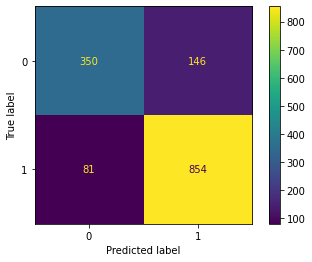

****************************************

****************************************
  GENRE: drama                         
````````````````````````````````````````
    Accuracy:         0.5884
    Precision:        0.5989
    Recall:           0.6046
    F1:               0.6018
    AUC:              0.5879
````````````````````````````````````````


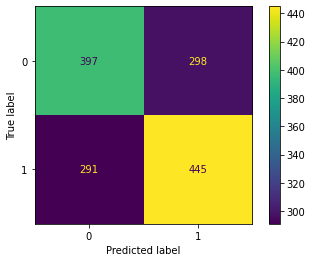

****************************************

****************************************
  GENRE: action                        
````````````````````````````````````````
    Accuracy:         0.8994
    Precision:        0.4065
    Recall:           0.5478
    F1:               0.4667
    AUC:              0.7390
````````````````````````````````````````


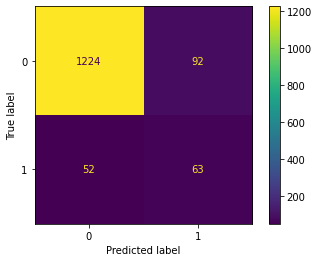

****************************************

****************************************
  GENRE: historical                    
````````````````````````````````````````
    Accuracy:         0.9462
    Precision:        0.7186
    Recall:           0.8720
    F1:               0.7879
    AUC:              0.9139
````````````````````````````````````````


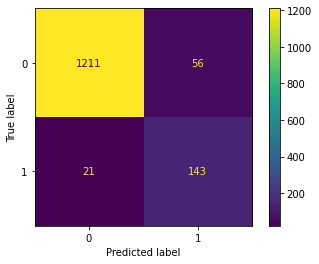

****************************************

****************************************
  GENRE: youth_school                  
````````````````````````````````````````
    Accuracy:         0.8896
    Precision:        0.5622
    Recall:           0.6595
    F1:               0.6070
    AUC:              0.7916
````````````````````````````````````````


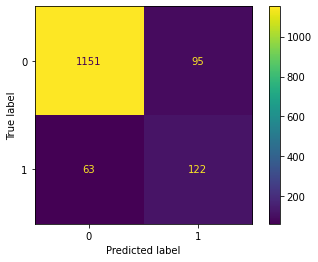

****************************************

****************************************
  GENRE: fantasy_supernatural_horror   
````````````````````````````````````````
    Accuracy:         0.8917
    Precision:        0.5694
    Recall:           0.6467
    F1:               0.6056
    AUC:              0.7873
````````````````````````````````````````


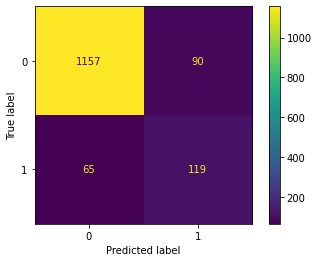

****************************************

****************************************
  GENRE: mystery                       
````````````````````````````````````````
    Accuracy:         0.8952
    Precision:        0.6190
    Recall:           0.6976
    F1:               0.6560
    AUC:              0.8129
````````````````````````````````````````


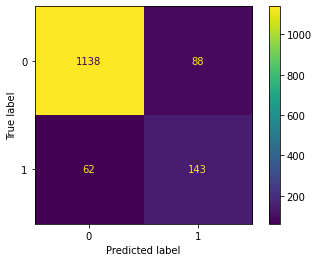

****************************************

****************************************
  GENRE: life                          
````````````````````````````````````````
    Accuracy:         0.8763
    Precision:        0.3563
    Recall:           0.4351
    F1:               0.3918
    AUC:              0.6779
````````````````````````````````````````


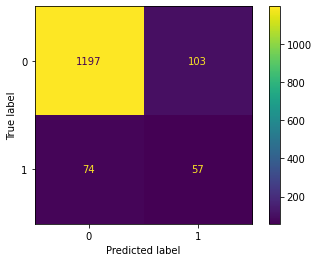

****************************************

****************************************
  GENRE: family                        
````````````````````````````````````````
    Accuracy:         0.8791
    Precision:        0.4734
    Recall:           0.6049
    F1:               0.5312
    AUC:              0.7595
````````````````````````````````````````


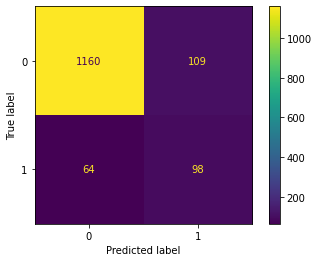

****************************************



In [14]:
metric_serlist = []
result_dfs = []

for genre in bat_targets:
    clf = clf_dict[genre]
    X_test,y_test = test_vars[genre]["X_test"],test_vars[genre]["y_test"]
    y_pred = clf.predict(X_test)
    
    metric_serlist.append(display_metrics(y_pred,y_test))
    
    result_dfs.append(get_result_df(y_pred))

In [15]:
metric_df = pd.concat(metric_serlist,axis=1)
metric_df

,romance,sitcom_comedy,comedy,war_historical,political_drama,thriller,friendship,melodrama_romance,drama,action,historical,youth_school,fantasy_supernatural_horror,mystery,life,family
accuracy,0.835080,0.759609,0.766597,0.944095,0.603075,0.897275,0.865828,0.841370,0.588400,0.899371,0.946191,0.889588,0.891684,0.895178,0.876310,0.879106
precision,0.847011,0.649351,0.651769,0.731343,0.642857,0.512987,0.321212,0.854000,0.598923,0.406452,0.718593,0.562212,0.569378,0.619048,0.356250,0.473430
recall,0.907709,0.693069,0.704225,0.849711,0.619898,0.523179,0.398496,0.913369,0.604620,0.547826,0.871951,0.659459,0.646739,0.697561,0.435115,0.604938
fl,0.876310,0.670498,0.676983,0.786096,0.631169,0.518033,0.355705,0.882687,0.601758,0.466667,0.787879,0.606965,0.605598,0.655963,0.391753,0.531165
auc,0.805815,0.744483,0.752006,0.903393,0.601294,0.732293,0.656105,0.809507,0.587921,0.738959,0.913876,0.791608,0.787283,0.812891,0.677942,0.759522


In [16]:
# save metrics

metric_df.to_json("model_metrics_bygenre.json")

In [17]:
# to compare genre sets

all_results = result_dfs[0]
for item in result_dfs[1:]:
    all_results = all_results.join(item)

In [18]:
# drop the genre_test columns since they are already in orig dataset
drop_testcols = [genre+"_test" for genre in bat_targets]
all_results.drop(columns=drop_testcols, inplace=True)

In [19]:
# adjust case for list of genres, change to set
def forgl(x):
    x2 = []
    for i in x:
        i = i.lower().replace(" ","_")
        x2.append(i)
    return set(x2)

test_compare = dataset.join(all_results, how="inner")
test_compare["genres"] = test_compare["genres"].apply(forgl)
print(test_compare.shape)
test_compare.head()

(1431, 49)


,country,crew,ep_duration,episodes,genres,id,main_cast,num_ratings,num_watchers,orig_network,...,friendship_pred,melodrama_romance_pred,drama_pred,action_pred,historical_pred,youth_school_pred,fantasy_supernatural_horror_pred,mystery_pred,life_pred,family_pred
1,Japan,"[/people/15966-ozaki-masaya, /people/16318-tae...",45 min.,11,"{melodrama_romance, romance, political_drama, ...",/2695-nisennen-no-koi,"[/people/1426-nakayama-miho, /people/518-kanes...",83,278,[Fuji TV],...,0,1,0,0,0,0,0,0,0,0
3,Thailand,"[/people/76819-phanom-thian, /people/15733-yam...",2 hr. 0 min.,11,"{melodrama_romance, romance, political_drama, ...",/13492-massaya,"[/people/7331-gregson-andrew, /people/9902-for...",71,174,[Channel 7],...,0,1,1,0,1,0,0,0,0,0
19,South Korea,"[/people/67407-kim-sun-young, /people/67289-le...",60 min.,16,"{melodrama_romance, romance, comedy, sitcom_co...",/2821-mr.-duke,"[/people/557-choi-ji-woo, /people/1198-kim-seu...",91,286,[MBC],...,0,1,0,0,0,0,0,0,0,0
20,Thailand,"[/people/16743-salaya-sukanivatt, /people/3753...",1 hr. 20 min.,20,"{drama, family, romance, political_drama, melo...",/14816-luk-mai-klai-ton,"[/people/7331-gregson-andrew, /people/8023-kon...",51,183,[Channel 7],...,0,1,1,0,0,0,0,0,0,1
21,South Korea,"[/people/67287-kim-sa-hyun, /people/67395-park...",1 hr. 5 min.,18,"{melodrama_romance, romance, political_drama, ...",/1209-secret-2000,"[/people/403-kim-ha-neul, /people/1249-kim-min...",75,361,[MBC],...,0,1,0,0,0,0,0,0,0,0


In [20]:
genres_pred_data = []

for index,row in test_compare.iterrows():
    # add genre to set if predicted
    genres_pred = set()
    for genre in bat_targets:
        pred_col = genre+"_pred"
        if row[pred_col] == 1:
            genres_pred.add(genre)
    genres_pred_data.append(genres_pred)

test_compare["genres_pred"] = genres_pred_data

test_compare[["genres","genres_pred"]]

,genres,genres_pred
1,"{melodrama_romance, romance, political_drama, ...","{melodrama_romance, romance}"
3,"{melodrama_romance, romance, political_drama, ...","{drama, war_historical, historical, political_..."
19,"{melodrama_romance, romance, comedy, sitcom_co...","{melodrama_romance, romance, comedy, sitcom_co..."
20,"{drama, family, romance, political_drama, melo...","{drama, family, political_drama, melodrama_rom..."
21,"{melodrama_romance, romance, political_drama, ...","{melodrama_romance, romance}"
...,...,...
4758,"{melodrama_romance, romance, political_drama, ...","{drama, fantasy_supernatural_horror, political..."
4761,"{thriller, mystery, fantasy_supernatural_horror}","{melodrama_romance, romance, drama, political_..."
4762,"{youth_school, sitcom_comedy, melodrama_romanc...","{sitcom_comedy, drama, youth_school, political..."
4764,"{comedy, sitcom_comedy, melodrama_romance, rom...","{drama, political_drama, melodrama_romance, ro..."


In [21]:
# jaccard similarity
## num in both sets / num in either set
## or intersect / union
def jaccard_sim(a,b):
    # assuming that a,b are already sets
    
    numer = len(a&b)
    denom = len(a|b)
    
    return numer/denom
 
jac_sim_data = []
    
for index,row in test_compare[["genres","genres_pred"]].iterrows():
    a,b = row
    jac_sim_data.append(jaccard_sim(a,b))
    
test_compare["jaccard_similarity"] = jac_sim_data
test_compare[["title","genres","genres_pred","jaccard_similarity"]]

,title,genres,genres_pred,jaccard_similarity
1,Nisennen no Koi,"{melodrama_romance, romance, political_drama, ...","{melodrama_romance, romance}",0.500000
3,Massaya,"{melodrama_romance, romance, political_drama, ...","{drama, war_historical, historical, political_...",0.666667
19,Mr. Duke,"{melodrama_romance, romance, comedy, sitcom_co...","{melodrama_romance, romance, comedy, sitcom_co...",1.000000
20,Luk Mai Klai Ton,"{drama, family, romance, political_drama, melo...","{drama, family, political_drama, melodrama_rom...",0.833333
21,Secret,"{melodrama_romance, romance, political_drama, ...","{melodrama_romance, romance}",0.500000
...,...,...,...,...
4758,Happenstance,"{melodrama_romance, romance, political_drama, ...","{drama, fantasy_supernatural_horror, political...",0.400000
4761,Kishibe Rohan wa Ugokanai,"{thriller, mystery, fantasy_supernatural_horror}","{melodrama_romance, romance, drama, political_...",0.000000
4762,A Love So Beautiful,"{youth_school, sitcom_comedy, melodrama_romanc...","{sitcom_comedy, drama, youth_school, political...",0.714286
4764,Irresistible Love,"{comedy, sitcom_comedy, melodrama_romance, rom...","{drama, political_drama, melodrama_romance, ro...",0.428571


In [22]:
import matplotlib.pyplot as plt

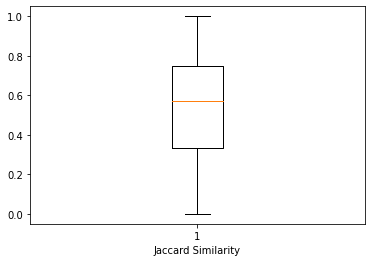

count    1431.000000
mean        0.548312
std         0.282724
min         0.000000
25%         0.333333
50%         0.571429
75%         0.750000
max         1.000000
Name: jaccard_similarity, dtype: float64

In [24]:
plt.boxplot(test_compare["jaccard_similarity"])
plt.xlabel("Jaccard Similarity")
plt.show()

test_compare["jaccard_similarity"].describe()

In [91]:
test_compare.to_json("dramainfo_revtested.json")